<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/WISDM/wisdm_CBAM%2Btransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('/content/drive/MyDrive/datasets/WISDM_ar_v1.1_raw.txt', header=None, on_bad_lines='skip').dropna()

In [3]:
df.columns=['user', 'activity', 'timestamp', 'x','y','z']
df['z']=df['z'].str.replace(';','')
df=df.drop(columns=['timestamp'])
df.head()

,user,activity,x,y,z
0,33,Jogging,-0.694638,12.680544,0.50395286
1,33,Jogging,5.012288,11.264028,0.95342433
2,33,Jogging,4.903325,10.882658,-0.08172209
3,33,Jogging,-0.612916,18.496431,3.0237172
4,33,Jogging,-1.184970,12.108489,7.205164


In [4]:
df['x']=df['x'].astype(float)
df['y']=df['y'].astype(float)
df['z']=df['z'].astype(float)

In [5]:
df.isnull().sum()

,0
user,0
activity,0
x,0
y,0
z,0


In [6]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
df['activity']=label.fit_transform(df['activity'])
df

,user,activity,x,y,z
0,33,1,-0.694638,12.680544,0.503953
1,33,1,5.012288,11.264028,0.953424
2,33,1,4.903325,10.882658,-0.081722
3,33,1,-0.612916,18.496431,3.023717
4,33,1,-1.184970,12.108489,7.205164
...,...,...,...,...,...
1086461,19,2,9.000000,-1.570000,1.690000
1086462,19,2,9.040000,-1.460000,1.730000
1086463,19,2,9.080000,-1.380000,1.690000
1086464,19,2,9.000000,-1.460000,1.730000


In [7]:
X=df.drop(columns=['activity'])
y=df['activity']
X

,user,x,y,z
0,33,-0.694638,12.680544,0.503953
1,33,5.012288,11.264028,0.953424
2,33,4.903325,10.882658,-0.081722
3,33,-0.612916,18.496431,3.023717
4,33,-1.184970,12.108489,7.205164
...,...,...,...,...
1086461,19,9.000000,-1.570000,1.690000
1086462,19,9.040000,-1.460000,1.730000
1086463,19,9.080000,-1.380000,1.690000
1086464,19,9.000000,-1.460000,1.730000


In [8]:
y

,activity
0,1
1,1
2,1
3,1
4,1
...,...
1086461,2
1086462,2
1086463,2
1086464,2


In [9]:
users=sorted(df['user'].unique())
print(users)

[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]


In [10]:
#train, test 분리
train_users=[u for u in users if u<=28]
val_users=[u for u in users if 28<u<=32]
test_users=[u for u in users if u>32]

#사용자 그룹에 따라 DataFrame 생성
train_df = df[df['user'].isin(train_users)].copy()
test_df  = df[df['user'].isin(test_users)].copy()
val_df=df[df['user'].isin(val_users)].copy()

print("-----사용자 기반 데이터 분할-----")
print(f"훈련용 사용자 수: {len(train_users)}명, 데이터 수: {len(train_df)}")
print(f"검증용 사용자 수: {len(val_users)}명, 데이터 수: {len(val_df)}")
print(f"테스트용 사용자 수: {len(test_users)}명, 데이터 수: {len(test_df)}")

-----사용자 기반 데이터 분할-----
훈련용 사용자 수: 28명, 데이터 수: 823043
검증용 사용자 수: 4명, 데이터 수: 143367
테스트용 사용자 수: 4명, 데이터 수: 120055


In [11]:
#데이터 스케일링
from sklearn.preprocessing import StandardScaler

features=['x','y','z']
scaler=StandardScaler()
#스케일링은 무조건 훈련 데이터 기준으로... 테스트 데이터 기준으로 하면=> 데이터 누수!!!!!
scaler.fit(train_df[features])

train_df[features]=scaler.transform(train_df[features])
val_df[features]=scaler.transform(val_df[features])
test_df[features]=scaler.transform(test_df[features])

In [12]:
import numpy as np
from scipy.stats import mode
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x'].values[i:i+time_steps]
        ys = df['y'].values[i:i+time_steps]
        zs = df['z'].values[i:i+time_steps]

        win_labels = df[label_name].values[i:i+time_steps].astype(int)
        label = np.bincount(win_labels).argmax()
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [13]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activity'

In [14]:
#훈련 데이터셋
x_train, y_train=segments(train_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#검증 데이터셋
x_val, y_val=segments(val_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#테스트 데이터셋
x_test, y_test=segments(test_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

In [15]:
#원핫인코딩
from tensorflow.keras.utils import to_categorical

num_classes=label.classes_.size
y_train_hot=to_categorical(y_train, num_classes)
y_val_hot=to_categorical(y_val, num_classes)
y_test_hot=to_categorical(y_test, num_classes)

print("훈련데이터:", x_train.shape, y_train_hot.shape)
print("검증데이터", x_val.shape, y_val_hot.shape)

훈련데이터: (20575, 80, 3) (20575, 6)
검증데이터 (3583, 80, 3) (3583, 6)


In [16]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIOD, 3, 1)
x_val = x_val.reshape(x_val.shape[0], TIME_PERIOD, 3, 1)
x_test = x_test.reshape(x_test.shape[0], TIME_PERIOD, 3, 1)

x_train.shape, x_val.shape

((20575, 80, 3, 1), (3583, 80, 3, 1))

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D,
                                     Dense, Reshape, multiply, Concatenate, Activation, Add,
                                     BatchNormalization, Dropout, MultiHeadAttention,
                                     LayerNormalization, GlobalAveragePooling1D, Layer)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

### 트랜스포머 인코더

In [18]:
class PositionalEncoding(layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding=self.positional_encoding(position, d_model)
  def get_angles(self, position, i, d_model):
    angles=1/tf.pow(10000, (2*(i//2))/tf.cast(d_model, tf.float32))
    return position*angles

  def positional_encoding(self, postion, d_model):
    angle_rads=self.get_angles(
        tf.range(postion, dtype=tf.float32)[:, tf.newaxis],
        tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model
    )
    sines=tf.math.sin(angle_rads[:,0::2])
    cosines=tf.math.cos(angle_rads[:, 1::2])

    pos_encoding=tf.concat([sines, cosines], axis=-1)
    pos_encoding=pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs+self.pos_encoding[:, :tf.shape(inputs)[1],:]


In [19]:
class TransformerEncoderBlock(Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerEncoderBlock, self).__init__()
    assert embed_dim%num_heads==0, f"embed_dim({embed_dim}) must be divisible by num_heads({num_heads})"
    self.head_dim=embed_dim//num_classes

    self.att=MultiHeadAttention(
        num_heads=num_heads, key_dim=self.head_dim
    )
    self.ffn=tf.keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(embed_dim),
    ])

    self.layernorm1=LayerNormalization(epsilon=1e-6)
    self.layernorm2=LayerNormalization(epsilon=1e-6)
    self.dropout1=Dropout(rate)
    self.dropout2=Dropout(rate)

  def call(self, inputs, training=False):
    #멀티헤드 어텐션
    attn_output=self.att(inputs, inputs, inputs)
    attn_output=self.dropout1(attn_output, training=training)
    out1=self.layernorm1(inputs+attn_output)
    #피드포워드
    ffn_output=self.ffn(out1)
    ffn_output=self.dropout2(ffn_output, training=training)
    out2=self.layernorm2(out1+ffn_output)
    return out2

### CBAM

In [20]:
#ratio=채널 축소 비율, MLP를 통과 하기 전에 정보를 압축하는 병목 구조를 위해 채널 어텐션에 사용한다.
#kernel_initializer='he_normal': 가중치 초기화 방법. ReLU와 함께 사용 시 성능이 좋다.
def channel_attention(input_feature, ratio=8):
  channel_axis=-1
  channel=input_feature.shape[channel_axis]

  #MLP 레이어 공유
  shared_layer_one=Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=False, bias_initializer='zeros')
  shared_layer_two=Dense(channel, kernel_initializer='he_normal', use_bias=False, bias_initializer='zeros')

  #Global Average Pooling
  avg_pool=GlobalAveragePooling2D()(input_feature)
  avg_pool=Reshape((1,1,channel))(avg_pool)
  avg_pool=shared_layer_one(avg_pool)
  avg_pool=shared_layer_two(avg_pool)

  #Global Max Pooling: CBAM은 average pooling과 max pooling을 병렬로 연결하는 모델
  max_pool=GlobalMaxPooling2D()(input_feature)
  max_pool=Reshape((1,1,channel))(max_pool)
  max_pool=shared_layer_one(max_pool)
  max_pool=shared_layer_two(max_pool)

  #풀링 결과 합산 후 sigmoid 함수 통과=>채널 가중치
  cbam_feature=Add()([avg_pool, max_pool])
  cbam_feature=Activation('sigmoid')(cbam_feature)
  #채널 가중치를 원본 특성맵과 곱함
  return multiply([input_feature, cbam_feature])

In [21]:
def spatial_attention(input_feature):
  kernel_size=7
  channel_axis=-1

  #채널 축에 대해 Average, Max pooling
  avg_pool=tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=channel_axis, keepdims=True))(input_feature)
  max_pool=tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=channel_axis, keepdims=True))(input_feature)

  #두 풀링 결과 결합
  concat=Concatenate(axis=channel_axis)([avg_pool, max_pool])

  #Conv 레이어, Sigmoid 통과
  cbam_feature=Conv2D(filters=1,
                      kernel_size=kernel_size,
                      strides=1,
                      padding='same',
                      activation='sigmoid',
                      kernel_initializer='he_normal',
                      use_bias=False)(concat)
  #원본 특성 맵과 곱
  return multiply([input_feature, cbam_feature])

In [22]:
def cbam_block(cbam_feature, ratio=8):
  #채널 어텐션
  cbam_feature=channel_attention(cbam_feature, ratio)
  #공간 어텐션
  cbam_feature=spatial_attention(cbam_feature)
  return cbam_feature

In [23]:
from tensorflow.keras.regularizers import l2

In [24]:
# 모델 정의
def create_transformer_cbam(input_shape, num_classes, num_transformer_blocks=2,
                            num_heads=8, cnn_filters=64):
  inputs=Input(shape=input_shape)
  #CNN+CBAM 특징 추출
  x=Conv2D(cnn_filters, kernel_size=(3,1), padding='same', activation='relu', kernel_regularizer=l2(0.001))(inputs)
  x=BatchNormalization()(x)
  x=Conv2D(cnn_filters, kernel_size=(3,1), padding="same", activation="relu", kernel_regularizer=l2(0.001))(x)
  x=BatchNormalization()(x)

  #CBAM 적용
  x=cbam_block(x)

  #트랜스포머 입력을 위한 reshape: (Batch, SeqLen, EmbeddingDim) 형태
  cnn_output_shape=x.shape
  seq_len=cnn_output_shape[1]
  embed_dim=cnn_output_shape[2]*cnn_output_shape[3]

  #멀티헤드 어텐션 요구 사항 확인
  #멀티헤드 어텐션은 어텐션 작업을 여러 개의 헤드로 쪼개서 병렬 수행한다.
  #따라서 나누어 떨어져야 동일한 크기로 쪼갤 수 있음...
  if embed_dim %num_heads!=0:
    raise ValueError(
        f"임베딩 차원 ({embed_dim})은 헤드 수 ({num_heads})로 나누어 떨어져야 한다."
    )
  x=Reshape((seq_len, embed_dim))(x)

  #포지셔널 인코딩
  pos_encoding_layer=PositionalEncoding(position=seq_len, d_model=embed_dim)
  x=pos_encoding_layer(x)
  x=Dropout(0.3)(x)

  #트랜스포머 인코더
  ff_dim=embed_dim*2

  for _ in range(num_transformer_blocks):
    x=TransformerEncoderBlock(embed_dim, num_heads, ff_dim)(x)

  #분류기
  x=GlobalAveragePooling1D()(x)
  x=Dropout(0.5)(x)
  outputs=Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

  model=Model(inputs=inputs, outputs=outputs)
  return model


In [35]:
#모델 학습
input_shape=x_train.shape[1:]
num_classes=y_train_hot.shape[1]

In [36]:
model=create_transformer_cbam(input_shape, num_classes, num_transformer_blocks=2,
                              num_heads=8, cnn_filters=64)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 80, 3, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 80, 3, 64) │        256 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 64) │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 80, 3, 64) │     12,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 64) │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1, 1, 8)   │        512 │ reshape_3[0][0],  │
│                     │                   │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1, 1, 64)  │        512 │ dense_7[0][0],    │
│                     │                   │            │ dense_7[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 1, 64)  │          0 │ dense_8[0][0],    │
│                     │                   │            │ dense_8[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1, 1, 64)  │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 80, 3, 64) │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 80, 3, 1)  │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 80, 3, 1)  │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 80, 3, 2)  │          0 │ lambda_2[0][0],   │
│ (Concatenate)       │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 80, 3, 1)  │         98 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 80, 3, 64) │          0 │ multiply_2[0][0], │
│ (Multiply)          │                   │            │ conv2d_5[0][0]  

 Total params: 708,136 (2.70 MB)

 Trainable params: 707,880 (2.70 MB)

 Non-trainable params: 256 (1.00 KB)

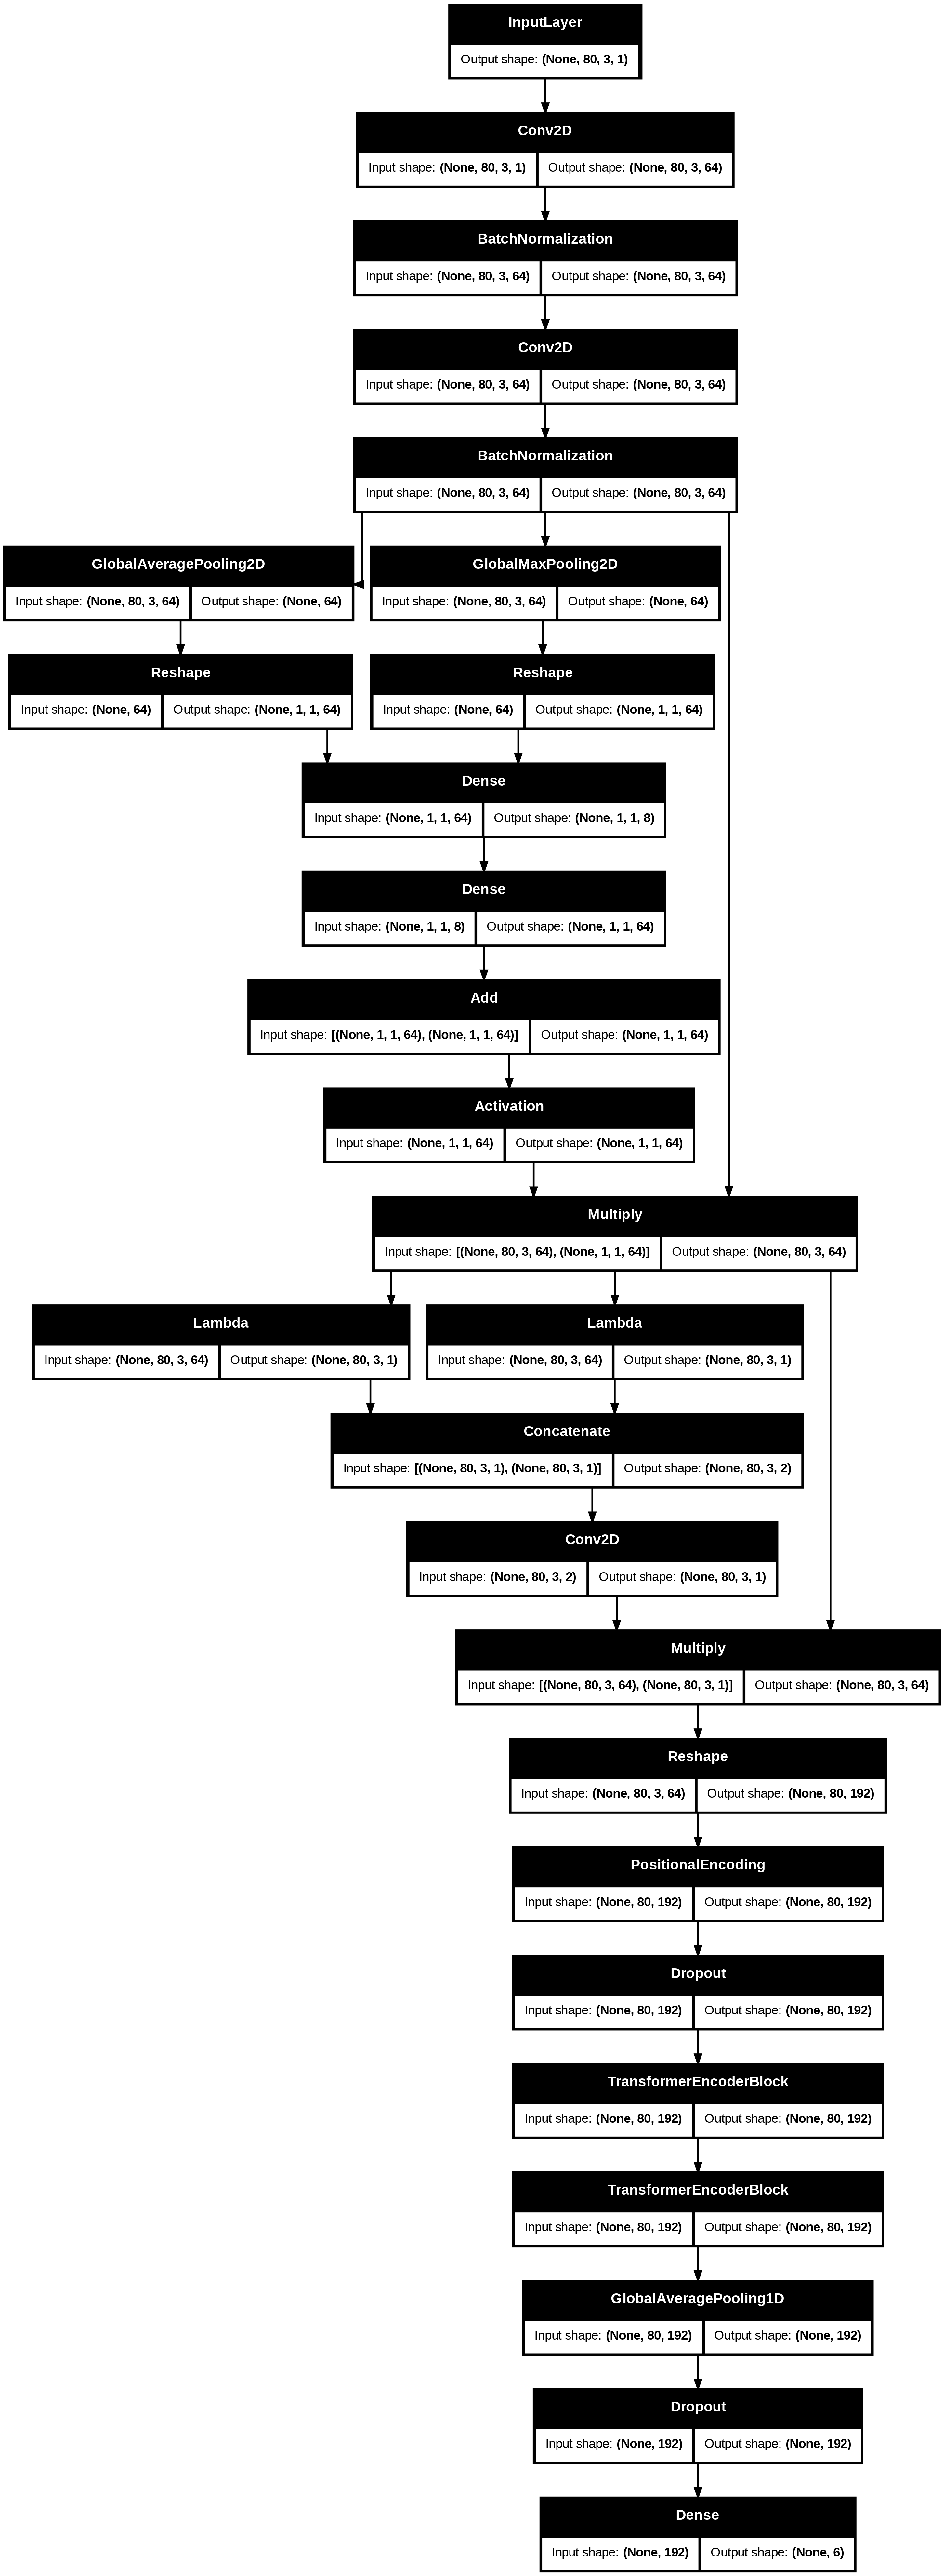

In [37]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history = model.fit(x_train, y_train_hot,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val_hot),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.7321 - loss: 0.8673 - val_accuracy: 0.8164 - val_loss: 0.7162 - learning_rate: 0.0010
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9015 - loss: 0.3374 - val_accuracy: 0.8180 - val_loss: 0.8808 - learning_rate: 0.0010
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9124 - loss: 0.3008 - val_accuracy: 0.8342 - val_loss: 0.6385 - learning_rate: 0.0010
Epoch 4/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9267 - loss: 0.2646 - val_accuracy: 0.8454 - val_loss: 0.6019 - learning_rate: 0.0010
Epoch 5/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9312 - loss: 0.2512 - val_accuracy: 0.8024 - val_loss: 0.7147 - learning_rate: 0.0010
Epoch 6/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9307 - loss: 0.2495 - val_accuracy: 0.8214 - val_loss: 0.6776 - learning_rate: 0.0010
Epoch 7/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9358 - loss: 

In [39]:
import matplotlib.pyplot as plt

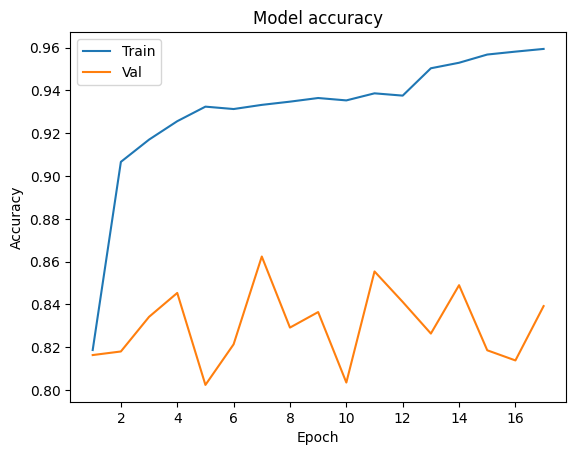

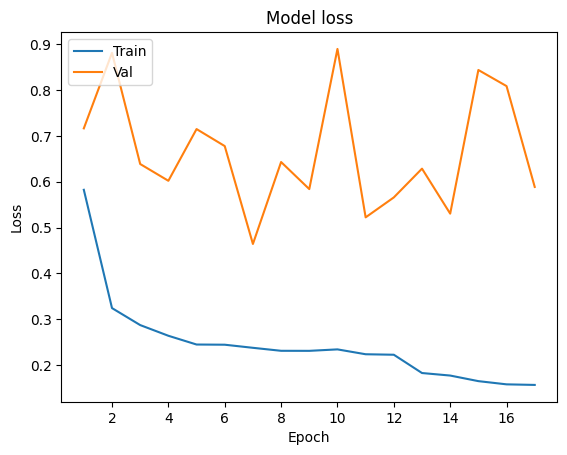

In [40]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epochs_run = len(history.history['loss'])
  epoch_range = range(1, epochs_run+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
plot_learningCurve(history, 50)

In [41]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


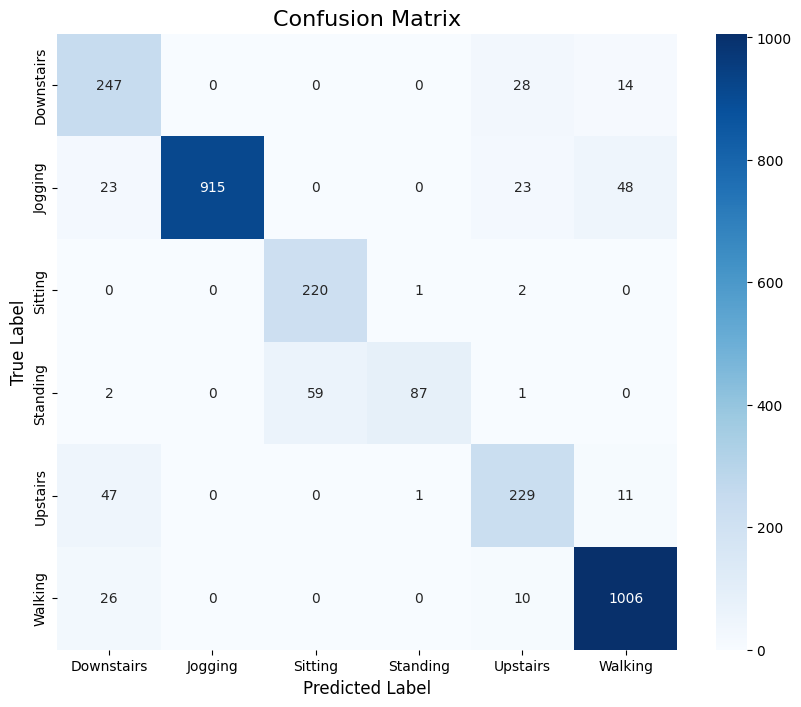

In [42]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

#혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

#시각화
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label.classes_, yticklabels=label.classes_)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [43]:

loss, accuracy = model.evaluate(x_test, y_test_hot, verbose=0)
print("="*30)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print("="*30)


테스트 데이터 정확도 (Accuracy): 0.9013
테스트 데이터 손실 (Loss): 0.4525


In [44]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n===== 분류 리포트 =====")
print(classification_report(y_test, y_pred, target_names=label.classes_))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

===== 분류 리포트 =====
              precision    recall  f1-score   support

  Downstairs       0.72      0.85      0.78       289
     Jogging       1.00      0.91      0.95      1009
     Sitting       0.79      0.99      0.88       223
    Standing       0.98      0.58      0.73       149
    Upstairs       0.78      0.80      0.79       288
     Walking       0.93      0.97      0.95      1042

    accuracy                           0.90      3000
   macro avg       0.87      0.85      0.85      3000
weighted avg       0.91      0.90      0.90      3000

